<a href="https://colab.research.google.com/github/Shubham2376G/trainingIBM/blob/main/Lemmitization_and_recommendation_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
import pandas as pd
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [65]:
df=pd.read_csv("/content/try.csv")

In [53]:
df

,label,data
0,1,Donald Trump has a devoted following
1,2,"hi, he is kissing"


In [30]:
def get_tag(text):
  if text.startswith("J"):
    return wordnet.ADJ
  elif text.startswith("V"):
    return wordnet.VERB
  elif text.startswith("N"):
    return wordnet.NOUN
  elif text.startswith("R"):
    return wordnet.ADV
  else:
    return wordnet.NOUN

In [64]:
def lemmatize_text1(text):

  lemmatizer = WordNetLemmatizer()
  words = nltk.word_tokenize(text.lower())
  tags=nltk.pos_tag(words)
  lemmatized_words=" ".join([(lemmatizer.lemmatize(word, get_tag(pos_tag))) for word, pos_tag in tags])

  # lemmatized_sentence = ' '.join(lemmatized_words)

  return lemmatized_words

In [66]:
df["data"]

0    Donald Trump has a devoted following
1                       hi, he is kissing
Name: data, dtype: object

In [67]:
df["data"]=df["data"].apply(lemmatize_text1)

In [68]:
df

,label,data
0,1,donald trump have a devote following
1,2,"hi , he be kiss"


In [ ]:
#recommander system

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
# https://www.kaggle.com/tmdb/tmdb-movie-metadata
!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

--2024-04-24 12:44:11--  https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5698602 (5.4M) [text/csv]
Saving to: ‘tmdb_5000_movies.csv’

tmdb_5000_movies.cs 100%[===================>]   5.43M  20.5MB/s    in 0.3s    

2024-04-24 12:44:12 (20.5 MB/s) - ‘tmdb_5000_movies.csv’ saved [5698602/5698602]



In [18]:
df = pd.read_csv('tmdb_5000_movies.csv')

In [19]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [20]:
df["genres"].values[:]

array(['[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]',
       '[{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}]',
       '[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 80, "name": "Crime"}]',
       ...,
       '[{"id": 35, "name": "Comedy"}, {"id": 18, "name": "Drama"}, {"id": 10749, "name": "Romance"}, {"id": 10770, "name": "TV Movie"}]',
       '[]', '[{"id": 99, "name": "Documentary"}]'], dtype=object)

In [23]:
def json_load(text):

  data=json.loads(text)
  return data

In [24]:
dataconverted=df["genres"].apply(json_load)

In [26]:
dataconverted[0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [37]:
dataconverted[0][0]["name"]

'Action'

In [38]:
try1=[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [42]:
def clean_join(text):
  data=" ".join("".join(id["name"].split()) for id in text)
  return data

In [43]:
clean_join(try1)

'Action Adventure Fantasy ScienceFiction'

In [44]:
def genres_and_keywords_to_string(row):
  genres = json.loads(row['genres'])
  genres = ' '.join(''.join(j['name'].split()) for j in genres)

  keywords = json.loads(row['keywords'])
  keywords = ' '.join(''.join(j['name'].split()) for j in keywords)
  return "%s %s" % (genres, keywords)

In [45]:
df['string'] = df.apply(genres_and_keywords_to_string, axis=1)

In [47]:
df["string"][0]

'Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d'

In [49]:
df["try"]=df["id"].astype(str) + " " + df["original_language"].astype(str)

In [50]:
df["try"]

0        19995 en
1          285 en
2       206647 en
3        49026 en
4        49529 en
          ...    
4798      9367 es
4799     72766 en
4800    231617 en
4801    126186 en
4802     25975 en
Name: try, Length: 4803, dtype: object

In [51]:
df["genres"]=df["genres"].apply(json_load)
df["genres"]=df["genres"].apply(clean_join)
df["keywords"]=df["keywords"].apply(json_load)
df["keywords"]=df["keywords"].apply(clean_join)

In [52]:
df["string"]=df["genres"].astype(str) + " " + df["keywords"].astype(str)

In [54]:
df["string"][0]

'Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d'

In [55]:
tfidf = TfidfVectorizer(max_features=2000)

In [56]:
X = tfidf.fit_transform(df['string'])

In [59]:
X

<4803x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 37285 stored elements in Compressed Sparse Row format>

In [64]:
idx=pd.Series(df.index, index=df["original_title"])

In [65]:
idx

original_title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [93]:
id=idx["Runaway Bride"]

In [94]:
query=X[id]

In [95]:
scores = cosine_similarity(query, X)
scores

array([[0.01682006, 0.        , 0.        , ..., 0.04766021, 0.        ,
        0.        ]])

In [96]:
scores = scores.flatten()

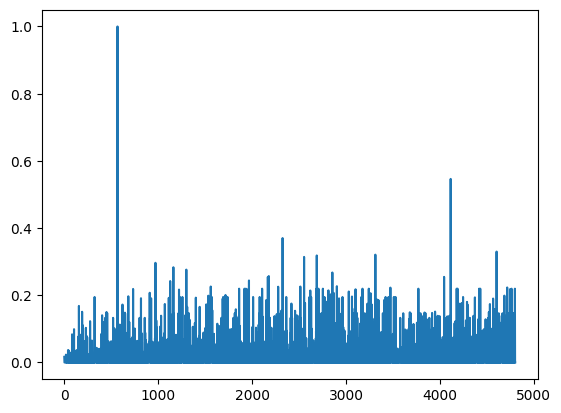

In [97]:
plt.plot(scores)

In [98]:
a=(-scores).argsort()

In [103]:
l1=a[1:6]

In [104]:
l1

array([4115, 2325, 4604, 3313, 2689])

In [105]:
idx1=pd.Series(df["original_title"])

In [106]:
idx1[l1]

4115                    House of D
2325    My Big Fat Greek Wedding 2
4604         It Happened One Night
3313                  An Education
2689            Our Family Wedding
Name: original_title, dtype: object